In [166]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import IFrame
from sklearn.model_selection import train_test_split
import numpy as np
from rasterstats import point_query
import rasterio
from mpl_toolkits.axes_grid1 import make_axes_locatable
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


In [23]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

In [24]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    
    # return the wrangled dataframe
    return X

def convert_to_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    gdf.crs = "EPSG:4326"
    return gdf

In [25]:
train = wrangle(train)
test = wrangle(test)

train_gdf = convert_to_gdf(train)
test_gdf = convert_to_gdf(test)

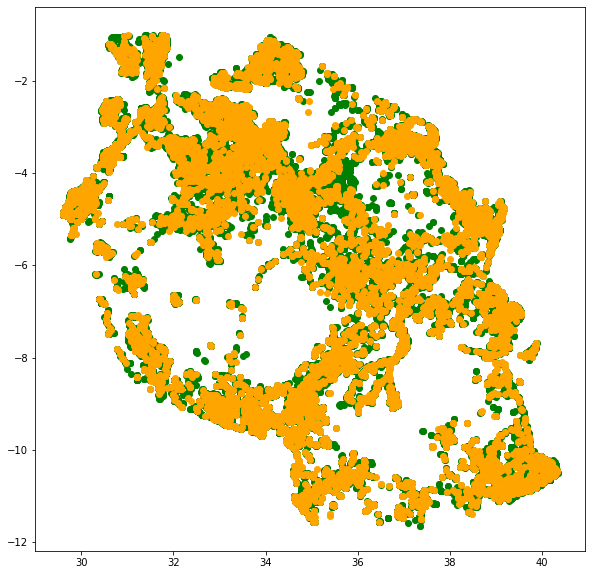

In [35]:
fig, ax = plt.subplots(figsize=(10,10))

train_gdf.plot(ax=ax, color="green")
test_gdf.plot(ax=ax, color="orange")

plt.show()

In [36]:
IFrame("https://data.humdata.org/dataset/2012-census-tanzania-wards-shapefiles", width="95%", height=400)

In [27]:
wards_data = "/home/alex/data/2012 Wards Shapefiles/TZwards.shp"
wards_gdf = gpd.read_file(wards_data)
wards_gdf.head()

,Region_Cod,Region_Nam,District_C,District_N,Ward_Code,Ward_Name,Division,SHAPE_Leng,SHAPE_Area,geometry
0,01,Dodoma,01,Kondoa,011,Bumbuta,None,0.769320,0.015383,"POLYGON ((35.93715 -4.59737, 35.93632 -4.59956..."
1,01,Dodoma,01,Kondoa,021,Pahi,None,0.450216,0.008900,"POLYGON ((35.93456 -4.61214, 35.93301 -4.61637..."
2,01,Dodoma,01,Kondoa,041,Haubi,None,0.538672,0.012175,"POLYGON ((35.92014 -4.74797, 35.92617 -4.74806..."
3,01,Dodoma,01,Kondoa,051,Kalamba,None,0.678941,0.023225,"POLYGON ((35.88398 -4.78581, 35.88743 -4.78581..."
4,01,Dodoma,01,Kondoa,061,Kwadelo,None,0.721114,0.025358,"POLYGON ((36.33663 -4.84585, 36.33696 -4.84824..."


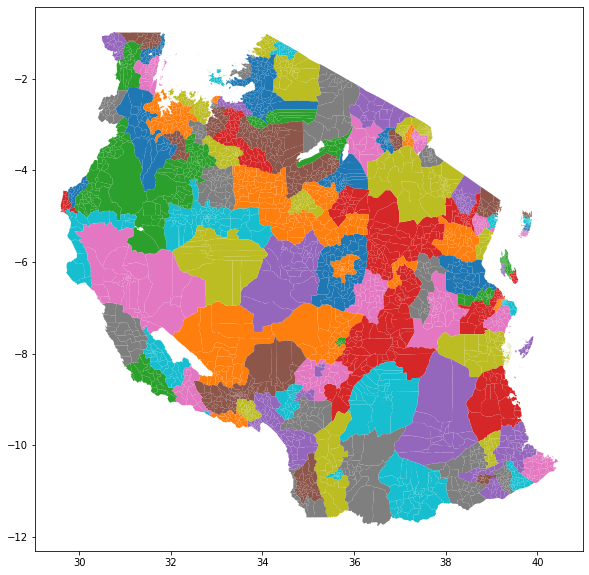

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
wards_gdf.plot("District_N", ax=ax)
plt.show()

In [29]:
wards_gdf_prj = wards_gdf.to_crs("EPSG:4326")

/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


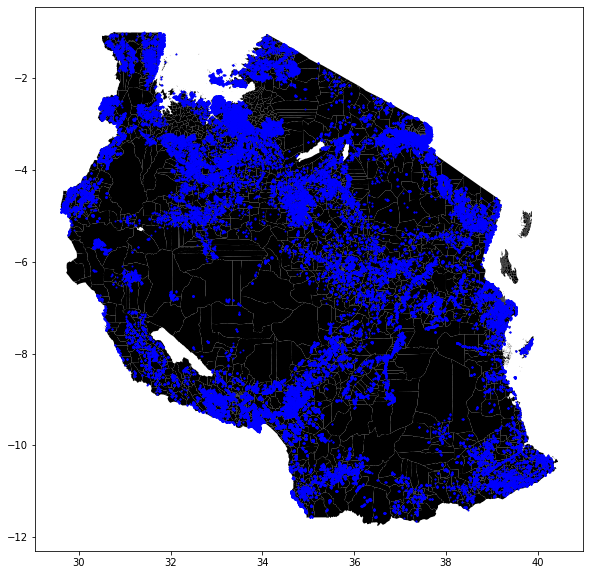

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

wards_gdf_prj.plot(ax=ax, color="black")
train_gdf.plot(ax=ax, color="blue", markersize=1)
test_gdf.plot(ax=ax, color="blue", markersize=1)

plt.show()

In [108]:
train_join = gpd.sjoin(train_gdf, wards_gdf_prj, how="left")
test_join = gpd.sjoin(test_gdf, wards_gdf_prj, how="left")

train_ward_key = train_join[["id","Region_Nam","District_N","Ward_Name","Division"]]
test_ward_key = test_join[["id","Region_Nam","District_N","Ward_Name","Division"]]


In [65]:
IFrame("http://opendata.rcmrd.org/datasets/tanzania-srtm-dem-30-meters", width="95%", height=500)

In [66]:
tif = "/home/alex/data/Tanzania_SRTM30meters/Tanzania_SRTM30meters.tif"
rasterio.open(tif).crs

CRS.from_epsg(4326)

In [72]:
train_for_pq = train_gdf[train_gdf["latitude"].notna()].copy()
test_for_pq = test_gdf[test_gdf["latitude"].notna()].copy()

In [73]:
train_elev = point_query(train_for_pq, tif, interpolate="nearest")
test_elev = point_query(test_for_pq, tif, interpolate="nearest")

In [75]:
train_for_pq["SRTM_elevation"] = train_elev
test_for_pq["SRTM_elevation"] = test_elev

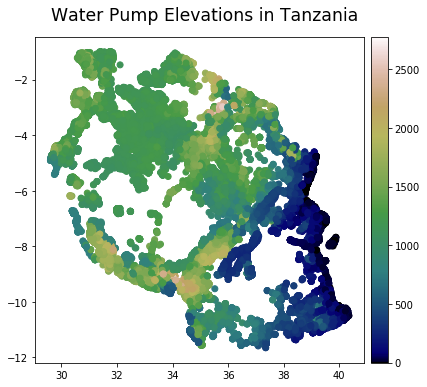

In [103]:
fig, ax = plt.subplots(figsize=(8,6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
train_for_pq.plot("SRTM_elevation", ax=ax, cax=cax, cmap="gist_earth", legend=True)
plt.suptitle("Water Pump Elevations in Tanzania", size="xx-large", y=0.95)
plt.show()

In [94]:
train_elev_key = train_for_pq[["id","SRTM_elevation"]].copy()
test_elev_key = test_for_pq[["id","SRTM_elevation"]].copy()

train_elev_key.head()

,id,SRTM_elevation
0,69572,1386.0
1,8776,1442.0
2,34310,698.0
3,67743,262.0
4,19728,1673.0


In [110]:
train = train.merge(train_ward_key, on="id", how="left").merge(train_elev_key, on="id", how="left").drop(["geometry"], axis=1)
test = test.merge(test_ward_key, on="id", how="left").merge(test_elev_key, on="id", how="left").drop(["geometry"], axis=1)

In [117]:
train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,year_recorded,month_recorded,day_recorded,years,years_MISSING,Region_Nam,District_N,Ward_Name,Division,SRTM_elevation
0,69572,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,2011,3,14,12.0,False,Njombe,Ludewa,Mundindi,None,1386.0
1,8776,0.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,2013,3,6,3.0,False,Mara,Serengeti,Ikoma,Grumeti,1442.0
2,34310,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,2013,2,25,4.0,False,Manyara,Simanjiro,Ngorika,None,698.0
3,67743,0.0,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,2013,1,28,27.0,False,Mtwara,Nanyumbu,Nanyumbu,Nanyumbu,262.0
4,19728,0.0,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,2011,7,13,NaN,True,Kagera,Karagwe,Nyakasimbi,Nyaishozi,1673.0


In [113]:
IFrame("https://data.humdata.org/dataset/413174ce-fc61-42eb-99e5-41a96c9fda2f", width="95%", height=400)

In [111]:
ward_population = pd.read_excel('/home/alex/Downloads/tza_pop_popn_nbs_baselinedata.xlsx')
ward_population.head()

,Reg_Code,Reg_Name,Dis_Code,Dis_Name,Ward_Code,Ward_Name,Division,PCode,total_both,total_male,...,rural_both,rural_male,urban_both,urban_male,urban_fema,rural_fema,area_km2,status,ward_type,Pop_Den
0,1,Dodoma,1,Kondoa,11,Bumbuta,NaN,101011,8602,4433,...,8602,4433,0,0,0,4169,189.981680,1,Rural,45
1,1,Dodoma,1,Kondoa,21,Pahi,NaN,101021,13944,7082,...,13944,7082,0,0,0,6862,109.924611,1,Rural,127
2,1,Dodoma,1,Kondoa,41,Haubi,NaN,101041,13757,7027,...,13757,7027,0,0,0,6730,150.395757,1,Rural,91
3,1,Dodoma,1,Kondoa,51,Kalamba,NaN,101051,13988,7023,...,13988,7023,0,0,0,6965,286.931082,1,Rural,49
4,1,Dodoma,1,Kondoa,61,Kwadelo,NaN,101061,11593,5801,...,11593,5801,0,0,0,5792,313.301277,1,Rural,37


In [125]:
ward_population_clean = ward_population[["Ward_Name","total_both","total_male","total_fema","rural_both","rural_male","rural_fema", "urban_both","urban_male","urban_fema","ward_type","Pop_Den"]]
ward_population_clean

,Ward_Name,total_both,total_male,total_fema,rural_both,rural_male,rural_fema,urban_both,urban_male,urban_fema,ward_type,Pop_Den
0,Bumbuta,8602,4433,4169,8602,4433,4169,0,0,0,Rural,45
1,Pahi,13944,7082,6862,13944,7082,6862,0,0,0,Rural,127
2,Haubi,13757,7027,6730,13757,7027,6730,0,0,0,Rural,91
3,Kalamba,13988,7023,6965,13988,7023,6965,0,0,0,Rural,49
4,Kwadelo,11593,5801,5792,11593,5801,5792,0,0,0,Rural,37
...,...,...,...,...,...,...,...,...,...,...,...,...
3638,Kamunyonge,5004,2303,2701,0,0,0,5004,2303,2701,Urban,4614
3639,Nyamatare,6527,3011,3516,0,0,0,6527,3011,3516,Urban,7730
3640,Mwisenge,13603,6243,7360,0,0,0,13603,6243,7360,Urban,5299
3641,Buhare,10129,4684,5445,0,0,0,10129,4684,5445,Urban,1026


In [126]:
train_prepped = train.merge(ward_population_clean, on="Ward_Name", how="left").drop_duplicates(["id"]).copy()
test_prepped = test.merge(ward_population_clean, on="Ward_Name", how="left").drop_duplicates(["id"]).copy()

In [128]:
train_prepped, validate_prepped = train_test_split(
    train_prepped, 
    train_size=0.80, 
    test_size=0.20, 
    stratify=train['status_group'], 
    random_state=42)

In [130]:
train_prepped.shape, validate_prepped.shape, test_prepped.shape

((47520, 63), (11880, 63), (14358, 62))

In [159]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train_prepped.drop(columns=[target, "id"])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features
categorical_features = cardinality.index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [160]:
X_train = train_prepped[features]
X_validate = validate_prepped[features]
X_test = test_prepped[features]

y_train = train_prepped[target]
y_validate = validate_prepped[target]

In [161]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, min_samples_leaf=2, max_depth=32, n_estimators=370, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_validate, y_validate))

0.9464856902356902
0.8132996632996633


In [162]:
y_pred = pipeline.predict(X_validate)
print(classification_report(y_validate, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.62      0.27      0.38       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.65      0.68     11880
           weighted avg       0.81      0.81      0.80     11880



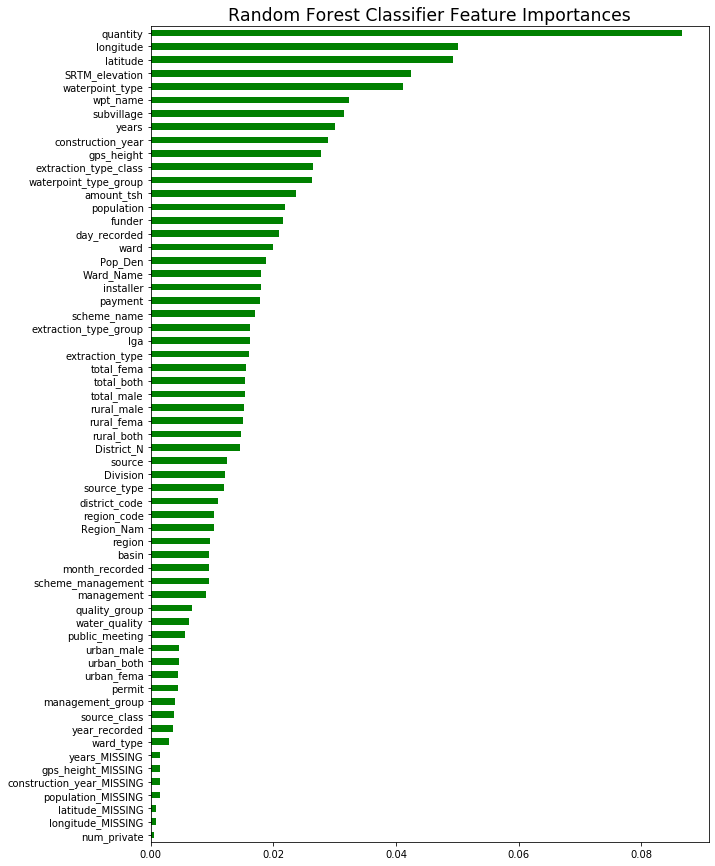

In [167]:
model = pipeline.named_steps["randomforestclassifier"]

encoder = pipeline.named_steps["ordinalencoder"]

encoded_columns = encoder.transform(X_validate).columns

importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(10,15))
importances.sort_values().plot(kind="barh", color="green")
plt.title("Random Forest Classifier Feature Importances", size="xx-large")
plt.show()